In [33]:
#importing required packages for pytorch

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [78]:
#writing custom Net() class from nn.model to define layers and architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 14, 3) #convoluation layer 1 
        self.bn1 = nn.BatchNorm2d(num_features=14) # batch normalization for conv1 output
        self.do1 = nn.Dropout(p=0.1) # dropout for conv1 output

        self.conv2 = nn.Conv2d(14, 16, 3) # 1x1 conv layer 2 
        self.bn2 = nn.BatchNorm2d(num_features=16) # batch norm for conv2 output channel
        self.do2 = nn.Dropout(p=0.1) 

        self.pool1 = nn.MaxPool2d(2, 2) 

        self.conv3 = nn.Conv2d(16, 32, 3) 
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.do3 = nn.Dropout(p=0.1)

        self.conv4 = nn.Conv2d(32, 16, 3)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.do4 = nn.Dropout(p=0.1)

        self.conv5 = nn.Conv2d(16, 14, 3)
        self.bn5 = nn.BatchNorm2d(num_features=14)
        self.do5 = nn.Dropout(p=0.1)

        self.conv6 = nn.Conv2d(14, 10, 5)
        self.bn6 = nn.BatchNorm2d(num_features=10)
        self.do6 = nn.Dropout(p=0.1)

        self.gap = nn.AdaptiveAvgPool2d((1, 1)) 

        self.linear1 = nn.Linear(12, 10)
        self.linear2 = nn.Linear(10, 10)

    def forward(self, x):
      x = self.do1(F.relu(self.bn1(self.conv1(x))))
      x = self.do2(F.relu(self.bn2(self.conv2(x))))

      x = self.pool1(x)

      x = self.do3(F.relu(self.bn3(self.conv3(x))))
      x = self.do4(F.relu(self.bn4(self.conv4(x))))
      x = self.do5(F.relu(self.bn5(self.conv5(x))))
      x = self.do6(F.relu(self.bn6(self.conv6(x))))



      x = self.gap(x)
      x=x.view(-1, 10)

      #x = F.relu(self.linear1(x))
      x = self.linear2(x)

      return F.log_softmax(x)

In [79]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             140
       BatchNorm2d-2           [-1, 14, 26, 26]              28
           Dropout-3           [-1, 14, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,032
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]           4,640
       BatchNorm2d-9           [-1, 32, 10, 10]              64
          Dropout-10           [-1, 32, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           4,624
      BatchNorm2d-12             [-1, 16, 8, 8]              32
    

<ipython-input-78-d90799a1bf55>:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [80]:
# setup train and test loader to create batch object of dataset
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


the label for below image is 4 



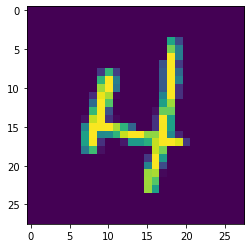

In [81]:
# Visualize data

import matplotlib.pyplot as plt
batch = next(iter(train_loader))
image = batch[0][0].squeeze().numpy()
label = batch[1][0]

plt.imshow(image)
print(f"the label for below image is {label} \n")



In [82]:
# function to train and evaluate 
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [83]:
# epochs 
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 19):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-78-d90799a1bf55>:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.12086963653564453 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]



Test set: Average loss: 0.0660, Accuracy: 9842/10000 (98.4200%)



loss=0.047105640172958374 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]



Test set: Average loss: 0.0348, Accuracy: 9896/10000 (98.9600%)



loss=0.05986561253666878 batch_id=468: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]



Test set: Average loss: 0.0317, Accuracy: 9899/10000 (98.9900%)



loss=0.021554915234446526 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]



Test set: Average loss: 0.0310, Accuracy: 9913/10000 (99.1300%)



loss=0.008834722451865673 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]



Test set: Average loss: 0.0291, Accuracy: 9918/10000 (99.1800%)



loss=0.01571638323366642 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]



Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.3300%)



loss=0.0705643892288208 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]



Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.2800%)



loss=0.02423100732266903 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]



Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.3300%)



loss=0.02119695208966732 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]



Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.3900%)



loss=0.033961083739995956 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.3700%)



loss=0.039219122380018234 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]



Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.3000%)



loss=0.006649520248174667 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]



Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.4100%)



loss=0.023747803643345833 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]



Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.3700%)



loss=0.019061079248785973 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]



Test set: Average loss: 0.0193, Accuracy: 9931/10000 (99.3100%)



loss=0.009254010394215584 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.3200%)



loss=0.05322651565074921 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 26.29it/s]



Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.4300%)



loss=0.051516756415367126 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.88it/s]



Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.4100%)



loss=0.016654478386044502 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]



Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.3200%)

